In [56]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import yaml
import time
from tqdm import tqdm

from erpe.analysis import *
from erpe.experiment_design import *
from erpe.models import *
from erpe.qcal_util import *
from erpe.lqr import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import qcal as qc

from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU
from qcal.backend.qubic.utils import qubic_sequence

from qcal.benchmarking.readout import ReadoutFidelity
from qcal.calibration.readout import ReadoutCalibration

from qcal.interface.pygsti.circuits import load_circuits
from qcal.interface.pygsti.transpiler import Transpiler
from qcal.interface.pygsti.datasets import generate_pygsti_dataset

In [3]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True

#cfg = qc.Config()
akel_config = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
akel_config.draw_qpu()

# Ramsey dual estimation

In [5]:
def theta_1qb_to_config_dict(theta):
    return {'freq': theta[0], 'amp': theta[1], 'phase': theta[2]}

In [13]:
# get the experiment design
depths_ramsey = [2**i for i in range(13)]
num_shots = 512

def make_ramsey_analysis_on_detuning_grid(detuning_grid, config, qid, depths, n_shots, classifier=classifier):
    initial_config = parse_control_params_from_cfg_1qb(config, qid)
    theta0 = [initial_config['freq'], initial_config['amp'], initial_config['phase']]
    edesign = EDesign_Ramsey(depths, [qid])
    analyses = {}
    for detuning in detuning_grid:
        print(f"Running Ramsey analysis for detuning = {detuning} on qubit {qid}")
        theta = theta0.copy()
        theta[0] += detuning
        new_config = make_new_config_from_old(config, qid, theta_1qb_to_config_dict(theta))
        print(parse_control_params_from_cfg_1qb(new_config, qid))
        dataset = make_dataset(new_config, edesign, n_shots, classifier)
        analysis = Analysis_Ramsey(dataset, edesign)
        analyses[detuning] = analysis
    return analyses

def analysis_dict_to_grid_estimates(analyses):
    grid_estimates = []
    for detuning, analysis in analyses.items():
        grid_estimates.append(analysis.estimates['idle'])
    return grid_estimates

In [65]:
max_detuning = 1e6 # kappa in paper
res = 5
detuning_grid = np.linspace(-max_detuning, max_detuning, res)
qids = ['Q1', 'Q2', 'Q3']
grid_estimates = {}
for qid in qids:
    analyses = make_ramsey_analysis_on_detuning_grid(detuning_grid, akel_config, qid, depths_ramsey, num_shots)
    # pickel the analyses dict
    with open(f'dual_estimation/ramsey_detuning_exp_{qid}.pkl', 'wb') as f:
        pickle.dump(analyses, f)
    grid_estimates[qid] = analysis_dict_to_grid_estimates(analyses)

    

Reading /home/jpmarceaux/experiment/data/2024-11-14/20241114_113132/RPE_dataset.txt: 100%


In [66]:
# pickel the grid estimates
with open('dual_estimation/ramsey_detuning_exp_grid_estimates.pkl', 'wb') as f:
    pickle.dump(grid_estimates, f)

In [70]:
grid_estimates

{'Q1': [-0.12338287743540421,
  -0.06067334478955777,
  0.002177404512060832,
  0.06444232033237718,
  0.12841889986447796],
 'Q2': [-0.12442934260781646,
  -0.061546073526370204,
  0.0022086858774130746,
  0.0661576336904659,
  0.12901365575288182],
 'Q3': [-0.0815909901010019,
  -0.04598083340333137,
  0.020448398722074046,
  0.023036080520235203,
  0.15902355904226084]}

Text(0.5, 0, 'Detuning (Hz)')

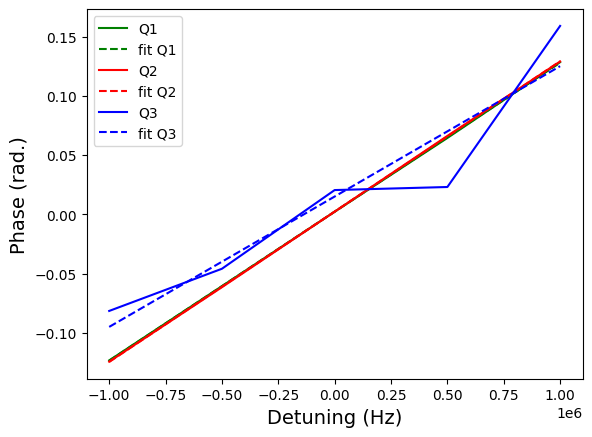

In [69]:
# fit a line to the grid estimates
fits = {qid : np.polyfit(detuning_grid, ge, 1) for qid, ge in grid_estimates.items()}

colors = {
    'Q0' : 'blue',
    'Q1' : 'green',
    'Q2' : 'red',
    'Q3' : 'blue'
}

# plot the fit on the grid estimates
plt.figure()
for qid, fit in fits.items():
    plt.plot(detuning_grid, grid_estimates[qid], label=qid, color=colors[qid])
    plt.plot(detuning_grid, np.polyval(fit, detuning_grid), label=f'fit {qid}', color=colors[qid], linestyle='--')
plt.legend()
plt.ylabel('Phase (rad.)', fontsize=14)
plt.xlabel('Detuning (Hz)', fontsize=14)



In [71]:
fits

{'Q1': array([1.25743844e-07, 2.19648050e-03]),
 'Q2': array([1.26917941e-07, 2.28091184e-03]),
 'Q3': array([1.10049202e-07, 1.49872430e-02])}

In [72]:
1/np.pi

0.3183098861837907

In [73]:
fit

array([1.10049202e-07, 1.49872430e-02])

# X-gate dual estimation

## Amplitude dual estimation

In [74]:
# make the experiment design
depths_xgate = [2**i for i in range(8)]
num_shots = 512

def make_xoverrot_analysis_on_amplitude_grid(amp_grid, config, qid, depths, n_shots, classifier=classifier):
    initial_config = parse_control_params_from_cfg_1qb(config, qid)
    theta0 = [initial_config['freq'], initial_config['amp'], initial_config['phase']]
    edesign = EDesign_Xoverrot(depths, [qid])
    analyses = {}
    for amp_offset in amp_grid:
        theta = theta0.copy()
        theta[1] += amp_offset
        new_config = make_new_config_from_old(config, qid, theta_1qb_to_config_dict(theta))
        dataset = make_dataset(new_config, edesign, n_shots, classifier)
        analysis = Analysis_Xoverrot(dataset, edesign)
        analyses[amp_offset] = analysis
    return analyses

def overrot_analysis_dict_to_grid_estimates(analyses):
    grid_estimates = []
    for amp_offset, analysis in analyses.items():
        grid_estimates.append(analysis.estimates['X overrot'])
    return grid_estimates


In [75]:
max_amp_offset = 0.005
res = 5
amp_grid = np.linspace(-max_amp_offset, max_amp_offset, res)
qids = ['Q1', 'Q2', 'Q3']
amp_grid_estimates = {}
for qid in qids:
    analyses = make_xoverrot_analysis_on_amplitude_grid(amp_grid, akel_config, qid, depths_xgate, num_shots)
    # pickel the analyses dict
    with open(f'dual_estimation/xoverrot_amp_exp_{qid}.pkl', 'wb') as f:
        pickle.dump(analyses, f)
    amp_grid_estimates[qid] = overrot_analysis_dict_to_grid_estimates(analyses)

Reading /home/jpmarceaux/experiment/data/2024-11-14/20241114_113545/RPE_dataset.txt: 100%


In [76]:
# pickel the grid estimates
with open('dual_estimation/xoverrot_amp_exp_grid_estimates.pkl', 'wb') as f:
    pickle.dump(amp_grid_estimates, f)

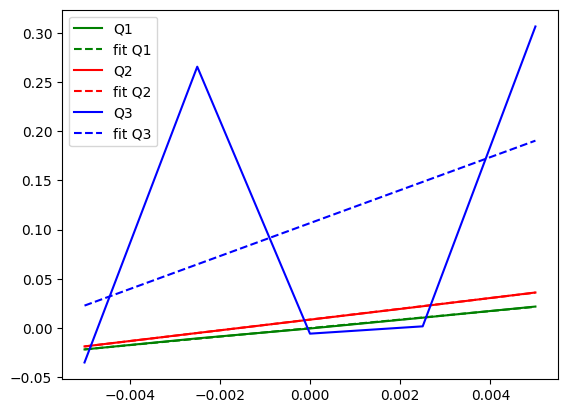

In [78]:
# fit and plot
fits = {qid : np.polyfit(amp_grid, ge, 1) for qid, ge in amp_grid_estimates.items()}

colors = {
    'Q0' : 'blue',
    'Q1' : 'green',
    'Q2' : 'red', 
    'Q3' : 'blue'
}

# plot the fit on the grid estimates
plt.figure()
for qid, fit in fits.items():
    plt.plot(amp_grid, amp_grid_estimates[qid], label=qid, color=colors[qid])
    plt.plot(amp_grid, np.polyval(fit, amp_grid), label=f'fit {qid}', color=colors[qid], linestyle='--')
plt.legend()

In [79]:
fits

{'Q1': array([ 4.32621449e+00, -1.56213337e-04]),
 'Q2': array([5.46962117, 0.00852671]),
 'Q3': array([16.75946727,  0.10651528])}

## Phase dual estimation

# CZ-gate dual estimation

In [80]:
parse_cz_control_params_from_cfg(akel_config, ['Q1', 'Q2'])

{'cz amp': 0.26536, 'cz vphase 1': 1.60701, 'cz vphase 2': -1.48246}

In [87]:
def make_cz_estimates_on_amp_grid(amp_grid, config, qids, depths, n_shots, classifier=classifier):
    initial_config = parse_cz_control_params_from_cfg(config, qids)
    theta0 = [initial_config['cz amp'], initial_config['cz vphase 1'], initial_config['cz vphase 2']]
    edesign = EDesign_CZ(depths, qids)
    analyses = {}
    for amp_offset in amp_grid:
        theta = theta0.copy()
        theta[0] += amp_offset
        new_config = make_new_cz_config_from_old(config, qids, theta_cz_to_config_dict(theta))
        dataset = make_dataset(new_config, edesign, n_shots, classifier)
        analysis = Analysis_CZ(dataset, edesign)
        analyses[amp_offset] = analysis
    return analyses

def cz_analysis_dict_to_grid_estimates(analyses):
    grid_estimates = []
    for amp_offset, analysis in analyses.items():
        grid_estimates.append([analysis.estimates['ZZ'], analysis.estimates['IZ'], analysis.estimates['ZI']])
    return grid_estimates

In [88]:
depths_cz = [2**i for i in range(6)]
qids = ['Q1', 'Q2']
cz_amp_max_offset = 0.005
res = 5
cz_amp_grid = np.linspace(-cz_amp_max_offset, cz_amp_max_offset, res)
analyses = make_cz_estimates_on_amp_grid(cz_amp_grid, akel_config, qids, depths_cz, num_shots)


Reading /home/jpmarceaux/experiment/data/2024-11-14/20241114_114038/RPE_dataset.txt: 100%


In [100]:
# pickle the analysis 
with open('dual_estimation/cz_amp_exp.pkl', 'wb') as f:
    pickle.dump(analyses, f)



In [101]:
cz_grid_estimates = cz_analysis_dict_to_grid_estimates(analyses)
# pickle the grid estimates
with open('dual_estimation/cz_amp_exp_grid_estimates.pkl', 'wb') as f:
    pickle.dump(cz_grid_estimates, f)

In [102]:
cz_grid_estimates = np.array(cz_grid_estimates)

Text(0.5, 0, 'CZ Amplitude (a.u.)')

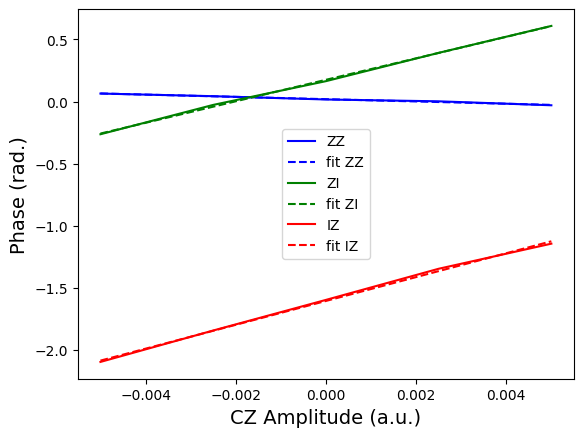

In [103]:
zz_grid_estimates = cz_grid_estimates[:, 0]
zi_grid_estimates = cz_grid_estimates[:, 1]
iz_grid_estimates = cz_grid_estimates[:, 2]
zz_fit = np.polyfit(cz_amp_grid, zz_grid_estimates, 1)
zi_fit = np.polyfit(cz_amp_grid, zi_grid_estimates, 1)
iz_fit = np.polyfit(cz_amp_grid, iz_grid_estimates, 1)

# plot with fits
plt.figure()
plt.plot(cz_amp_grid, zz_grid_estimates, label='ZZ', color='blue')
plt.plot(cz_amp_grid, np.polyval(zz_fit, cz_amp_grid), label='fit ZZ', color='blue', linestyle='--')
plt.plot(cz_amp_grid, zi_grid_estimates, label='ZI', color='green')
plt.plot(cz_amp_grid, np.polyval(zi_fit, cz_amp_grid), label='fit ZI', color='green', linestyle='--')
plt.plot(cz_amp_grid, iz_grid_estimates, label='IZ', color='red')
plt.plot(cz_amp_grid, np.polyval(iz_fit, cz_amp_grid), label='fit IZ', color='red', linestyle='--')
plt.legend()
plt.ylabel('Phase (rad.)', fontsize=14)
plt.xlabel('CZ Amplitude (a.u.)', fontsize=14)


In [99]:
print(zz_fit, zi_fit, iz_fit)

[-9.1976732   0.01886845] [86.5182117   0.17462214] [96.05008443 -1.60558358]
